### Import Libraries

In [1]:
import polars as pl
from statsmodels.regression.mixed_linear_model import MixedLM
from tabulate import tabulate
from scipy.stats import wilcoxon, ttest_rel, shapiro, stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Daten Vorbereiten

### Importieren der Files

In [2]:
questionaires_raw = pl.read_csv("questionaires.csv")
question_results_raw = pl.read_csv("questionResults.csv")
test_condition_orders_raw = pl.read_csv("testConditionOrders.csv")
fav = pl.read_csv("FAV.csv")

# drop rows where PersonID is = 0 or 23, because 0 was for testing and 23 did not do the learning evaluation
questionaires = questionaires_raw.filter(pl.col("PersonID") != 0).filter(pl.col("PersonID") != 23)
question_results = question_results_raw.filter(pl.col("PersonID") != 0).filter(pl.col("PersonID") != 23)
test_condition_orders = test_condition_orders_raw.filter(pl.col("PersonID") != 0).filter(pl.col("PersonID") != 23)

### Definition der Skalen 

In [3]:
# define questions for the different scales/items

efficiancy_questions = [
    "Zum Lernen empfinde ich die Anwendung als:",
]
learning_question = [
    "Ich konnte gut mit dem LLM-Agenten lernen",
]

information_question = [
    "Ich konnte die Informationen gut verstehen",
]

stimulation_questions = [
    "Die Beschäftigung mit der Lernanwendung empfinde ich als:",
]
visual_question = [
    "Die Gestaltung des LLM-Agenten hat mir gefallen",
]

motivation_questions = [
    "Der LLM-Agent hat mich Motiviert",
]

social_questions = [
    "Ich hatte das Gefühl mit einer Person in der virtuellen Umgebung zu interagieren statt mit einer Computer-Simulation",
]

Sprachassistent = [
    "Die Antworten und Fragen des LLM-Agenten sind:",
]
Nützlichkeit = [
    "Die Möglichkeit die Lernanwendung zu nutzen empfinde ich als:",
]
Rolle_Motivator = [
    "Die Nennung des meines eigenen Namens während der Nutzung empfand ich als motivierend",
]
Rolle_Organisator = [
    "Die Möglichkeit mir durch den LLM-Agenten Komponenten markieren zu lassen war nützlich",
]
Rolle_Tutor = [
    "Durch die Abfrage des LLM Agenten konnte ich die Komponenten gut lernen",
]

Rolle_Tutor2 = [
    "Die Zusammenfassung meiner Lernsession hat mir beim Lernen geholfen.",
]


### Erstellen der Scores

#### für gesamt UX

In [4]:
# Antwortqualität-Score, it has to be divided by 4 because the scale was 1-4
Antwortqualität = (
    questionaires.filter(pl.col("Question").is_in(Sprachassistent))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Antwortqualität"))
 ).with_columns(
     (pl.col("Antwortqualität")/4).alias("Antwortqualität")
    )

# Nützlichkeit-Score, it has to be divided by 4 because the scale was 1-4
Nützlichkeit_df = (
    questionaires.filter(pl.col("Question").is_in(Nützlichkeit))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Nützlichkeit"))
 ).with_columns(
     (pl.col("Nützlichkeit")/4).alias("Nützlichkeit")
     )

# Rolle_Motivator-Score
Rolle_Motivator_score = (
    questionaires.filter(pl.col("Question").is_in(Rolle_Motivator))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Rolle_Motivator_Score"))
)

# Rolle_Organisator-Score 
Rolle_Organisator_score = (
    questionaires.filter(pl.col("Question").is_in(Rolle_Organisator))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Rolle_Organisator_Score"))
)

# Rolle_Tutor-Score 
Rolle_Tutor_score = (
    questionaires.filter(pl.col("Question").is_in(Rolle_Tutor))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Rolle_Tutor_Score"))
)

# Rolle_Tutor2-Score 
Rolle_Tutor2_score = (
    questionaires.filter(pl.col("Question").is_in(Rolle_Tutor2))
    .group_by(["PersonID"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Rolle_Tutor2_Score"))
)

#### für Conditions

In [5]:
# it has to be divided by 4 because the scale was 1-4
efficiancy_score = (
    questionaires.filter(pl.col("Question").is_in(efficiancy_questions))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Efficiancy_Score"))
 ).with_columns(
     (pl.col("Efficiancy_Score") / 4).alias("Effizienz Wertung")
 )

# it has to be divided by 4 because the scale was 1-4
stimulation_score = (
    questionaires.filter(pl.col("Question").is_in(stimulation_questions))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Stimulation_Score"))
).with_columns(
    (pl.col("Stimulation_Score") / 4).alias("Stimulations Wertung")
)

Lerneffizienz = (
    questionaires.filter(pl.col("Question").is_in(learning_question))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Lerneffizienz"))
)

Informationsverständnis = (
    questionaires.filter(pl.col("Question").is_in(information_question))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Informationsverständnis"))
)

Gestaltung = (
    questionaires.filter(pl.col("Question").is_in(visual_question))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Gestaltung"))
)

social_score = (
    questionaires.filter(pl.col("Question").is_in(social_questions))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Soziale Präsenz"))
)

Motivation = (
    questionaires.filter(pl.col("Question").is_in(motivation_questions))
    .group_by(["PersonID", "Condition"])
    .agg((pl.col("Answer").cast(float).sum()).alias("Motivation"))
)

### Zusammenfügen der Scores in eine Tabelle

In [6]:
# All final (gesamt) UX scores in one dataframe
final_ux_scores = (
    Antwortqualität.join(Nützlichkeit_df, on=["PersonID"], how="inner")
    .join(Rolle_Motivator_score, on=["PersonID"], how="inner")
    .join(Rolle_Organisator_score, on=["PersonID"], how="inner")
    .join(Rolle_Tutor_score, on=["PersonID"], how="inner")
    .join(Rolle_Tutor2_score, on=["PersonID"], how="inner")
)

# put all scores together in a Conditions dataframe
condition_ux_scores = efficiancy_score.join(
    stimulation_score, 
    on=["PersonID", "Condition"], 
    how="inner").join(social_score, 
    on=["PersonID", "Condition"], 
    how="inner").join(Motivation, 
    on=["PersonID", "Condition"], 
    how="inner").join(Lerneffizienz,
    on=["PersonID", "Condition"],
    how="inner").join(Gestaltung,
    on=["PersonID", "Condition"],
    how="inner").join(Informationsverständnis,
    on=["PersonID", "Condition"],
    how="inner")
condition_ux_scores = condition_ux_scores.filter(pl.col("Condition").is_not_null())

#### Berechne den UX Score und normalisiere ihn

In [7]:
# Calculeate combined UX Score for each person and condition
condition_ux_scores = condition_ux_scores.with_columns(
    (pl.col("Effizienz Wertung").cast(float) + 
     pl.col("Stimulations Wertung").cast(float)).alias("UX_Score") 
)
# ux score min max normalization
condition_ux_scores = condition_ux_scores.with_columns(
    ((pl.col("UX_Score") - pl.col("UX_Score").min()) / (pl.col("UX_Score").max() - pl.col("UX_Score").min())).alias("Normalized_UX_Score")
)

#### Füge Test Results hinzu

In [8]:
# Remove the PreTest questions because they are not needed
question_results = question_results.filter(pl.col("TestCondition").eq("PostTest"))
test_condition_orders = test_condition_orders_raw.unique()

# Explode the components column
test_condition_orders_exploded = (
    test_condition_orders.with_columns(
        Components=pl.col("Components").str.extract_all(r"(\d+)")
    )
    .explode("Components")
    .with_columns(pl.col("Components").cast(pl.Int64).alias("Component"))
).select("PersonID", "Condition", "Component")

# remove duplicates
test_condition_orders_exploded = test_condition_orders_exploded.unique()
question_results = question_results.unique(subset=["PersonID", "CorrectComponent", "TestCondition"])
question_results.filter(question_results.is_duplicated())

learning_results = question_results.join(
    test_condition_orders_exploded,
    left_on=["PersonID", "CorrectComponent"],
    right_on=["PersonID", "Component"],
    how="left",
    validate="1:1",
)

assert learning_results["Condition"].null_count() == 0

# Combine the learning results with the UX scores

conditions_ux_learning = learning_results.join(
    condition_ux_scores,
    on=["PersonID", "Condition"],
    how="inner",
).drop(["TestCondition","CorrectComponent", "SelectedComponent"])


Jetzt sind alle dataframes vorbereitet und die Analyse beginnt

# Analyse

## Reihenfolgen Zählen
Wie oft kommt jede Reihenfolge der Testbedingungen insgesamt vor?

In [9]:
test_condition_orders = test_condition_orders_raw.to_pandas()

df_seq = test_condition_orders.groupby("PersonID", sort=False)["Condition"].apply(list).reset_index(name="ConditionSequence")
df_seq["ConditionSequenceTuple"] = df_seq["ConditionSequence"].apply(tuple)

sequence_counts = df_seq["ConditionSequenceTuple"].value_counts().reset_index()
sequence_counts.columns = ["ConditionSequenceTuple", "Anzahl"]

# print the whole dataframe
print(tabulate(sequence_counts, headers='keys', tablefmt='psql'))


+----+------------------------------------------------------------------------------------------------------------------------------------------+----------+
|    | ConditionSequenceTuple                                                                                                                   |   Anzahl |
|----+------------------------------------------------------------------------------------------------------------------------------------------+----------|
|  0 | ('ECA + Audio', 'ECA + Audio', 'ECA + kein Audio', 'ECA + kein Audio', 'UI + kein Audio', 'UI + kein Audio', 'UI + Audio', 'UI + Audio') |        3 |
|  1 | ('UI + kein Audio', 'UI + kein Audio', 'UI + Audio', 'UI + Audio', 'ECA + kein Audio', 'ECA + kein Audio', 'ECA + Audio', 'ECA + Audio') |        3 |
|  2 | ('ECA + kein Audio', 'ECA + kein Audio', 'ECA + Audio', 'ECA + Audio', 'UI + Audio', 'UI + Audio', 'UI + kein Audio', 'UI + kein Audio') |        3 |
|  3 | ('UI + Audio', 'UI + Audio', 'UI + kein Audio', 'UI

## Cronbachs Alpha 

### für die einzelnen Scores

In [10]:
def cronbach_alpha(df):
    item_variances = df.var(axis=0, ddof=1)
    total_variances = df.sum(axis=1).var(ddof=1)
    number_of_items = len(item_variances)
    return (number_of_items / (number_of_items - 1)) * (1 - item_variances.sum() / total_variances)

def calculate_cronbach_for_conditions(df, conditions, scale_name):
    for cond in conditions:
        df_cond = df[df["Condition"] == cond]
        if df_cond.empty:
            print(f"Keine Daten für Condition: {cond}")
            continue
        df_pivot = df_cond.pivot(index='PersonID', columns='left', values='Answer')
        alpha = cronbach_alpha(df_pivot).round(2)
        print(f"Cronbach's Alpha for {scale_name} in {cond}: {alpha}")


# Define all conditions in a list
conditions_list = ["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"]


efficiancy_questions_df = questionaires.filter(pl.col("Question").is_in(efficiancy_questions))
efficiancy_questions_df = efficiancy_questions_df.drop("Question", "right").to_pandas()

calculate_cronbach_for_conditions(efficiancy_questions_df, conditions_list, "Efficiancy")

stimulation_questions_df = questionaires.filter(pl.col("Question").is_in(stimulation_questions))
stimulation_questions_df = stimulation_questions_df.drop("Question", "right").to_pandas()

calculate_cronbach_for_conditions(stimulation_questions_df, conditions_list, "Stimulation")




Cronbach's Alpha for Efficiancy in ECA + Audio: 0.76
Cronbach's Alpha for Efficiancy in ECA + kein Audio: 0.7
Cronbach's Alpha for Efficiancy in UI + Audio: 0.38
Cronbach's Alpha for Efficiancy in UI + kein Audio: 0.39
Cronbach's Alpha for Stimulation in ECA + Audio: 0.98
Cronbach's Alpha for Stimulation in ECA + kein Audio: 0.94
Cronbach's Alpha for Stimulation in UI + Audio: 0.85
Cronbach's Alpha for Stimulation in UI + kein Audio: 0.89


In [11]:
# nützlichkeit
nützlichkeit_questions_df = questionaires.filter(pl.col("Question").is_in(Nützlichkeit))
nützlichkeit_questions_df = nützlichkeit_questions_df.drop("Question", "right").to_pandas()
df_piviot_nützlichkeit = nützlichkeit_questions_df.pivot(index='PersonID', columns='left', values='Answer')

cronbach_alpha_nützlichkeit = cronbach_alpha(df_piviot_nützlichkeit)

# Sprachassistent
Sprachassistent_questions_df = questionaires.filter(pl.col("Question").is_in(Sprachassistent))
Sprachassistent_questions_df = Sprachassistent_questions_df.drop("Question", "right").to_pandas()
df_piviot_Sprachassistent = Sprachassistent_questions_df.pivot(index='PersonID', columns='left', values='Answer')
cronbach_alpha_Sprachassitent = cronbach_alpha(df_piviot_Sprachassistent)

# print
print(f"Cronbach's Alpha for Nützlichkeit: {cronbach_alpha_nützlichkeit}")
print(f"Cronbach's Alpha for Sprachassistent: {cronbach_alpha_Sprachassitent}")



Cronbach's Alpha for Nützlichkeit: 0.9812293382641339
Cronbach's Alpha for Sprachassistent: 0.7748031496062993


## Descriptive Statistik

### UX Scores, Combined UX Score, Testresult by Condition

In [12]:
# aggregation of the values for each person and condition
agg_df = conditions_ux_learning.group_by(['PersonID', 'Condition']).agg([
    pl.mean("TestResult").alias("TestResult"),
    pl.mean("Effizienz Wertung").alias("Effizienz Wertung"),
    pl.mean("Stimulations Wertung").alias("Stimulations Wertung"),
    pl.mean("Soziale Präsenz").alias("Soziale Präsenz"),
    pl.mean("Motivation").alias("Motivation"),
    pl.mean("Lerneffizienz").alias("subjektiver Lernerfolg"),
    pl.mean("Gestaltung").alias("Gestaltung"),
    pl.mean("Informationsverständnis").alias("Informationsverständnis"),
    pl.mean("Normalized_UX_Score").alias("UX_Score")
])

# list of dependent variables
variables = ["TestResult",
                "Effizienz Wertung",
                "Stimulations Wertung",
                "Soziale Präsenz", 
                "Motivation",
                "subjektiver Lernerfolg",
                "Gestaltung",
                "Informationsverständnis", 
                "UX_Score"]

# bring the data into long format
long_df = agg_df.unpivot(
    index=["PersonID", "Condition"],
    on=variables,
    variable_name="Variable",
    value_name="Value"
)

# calculate the median, mean, std and count for each variable and condition
stats_df = long_df.group_by(["Variable", "Condition"]).agg([
    pl.median("Value").alias("Median").round(2),
    pl.mean("Value").alias("Mean").round(2),
    pl.std("Value").alias("StdDev").round(2),
    pl.count("Value").alias("Count").round(2)
])


In [13]:
stats_df_pd = stats_df.to_pandas()
stats_df_pd = stats_df_pd.sort_values(by=["Variable", "Condition"])

stats_df_pd['Variable_Label'] = stats_df_pd['Variable']
stats_df_pd.loc[stats_df_pd.duplicated(subset=['Variable']), 'Variable_Label'] = ''

# Order the columns
stats_df_pd_all = stats_df_pd[['Variable_Label', 'Condition', 'Median', 'Mean', 'StdDev', 'Count']]


### Styling Graphes

In [14]:
sns.set_theme(style="whitegrid")
sns.set_style("whitegrid")
my_pal = {"ECA + Audio": "#F57C00", 
          "UI + Audio": "#00FFBB", 
          "ECA + kein Audio": "#652CB3", 
          "UI + kein Audio": "#4C8491", 
          "Audio" : "#FFFB00", 
          "Kein Audio" : "#79F824",
          "ECA" : "#E80D1F",
          "UI" : "#1e88e5",
          "Antwortqualität" : "#484D6D",
          "Nützlichkeit" : "#E7A977",
          "Namensnennung" : "#95190C",
          "Highlighting Funktion" : "#3EC300",
          "Abfrage Funktion" : "#CEFF1A",
          "Lernzusammenfassung" : "#C61E5E",
          }

### Ergänzende Fragen

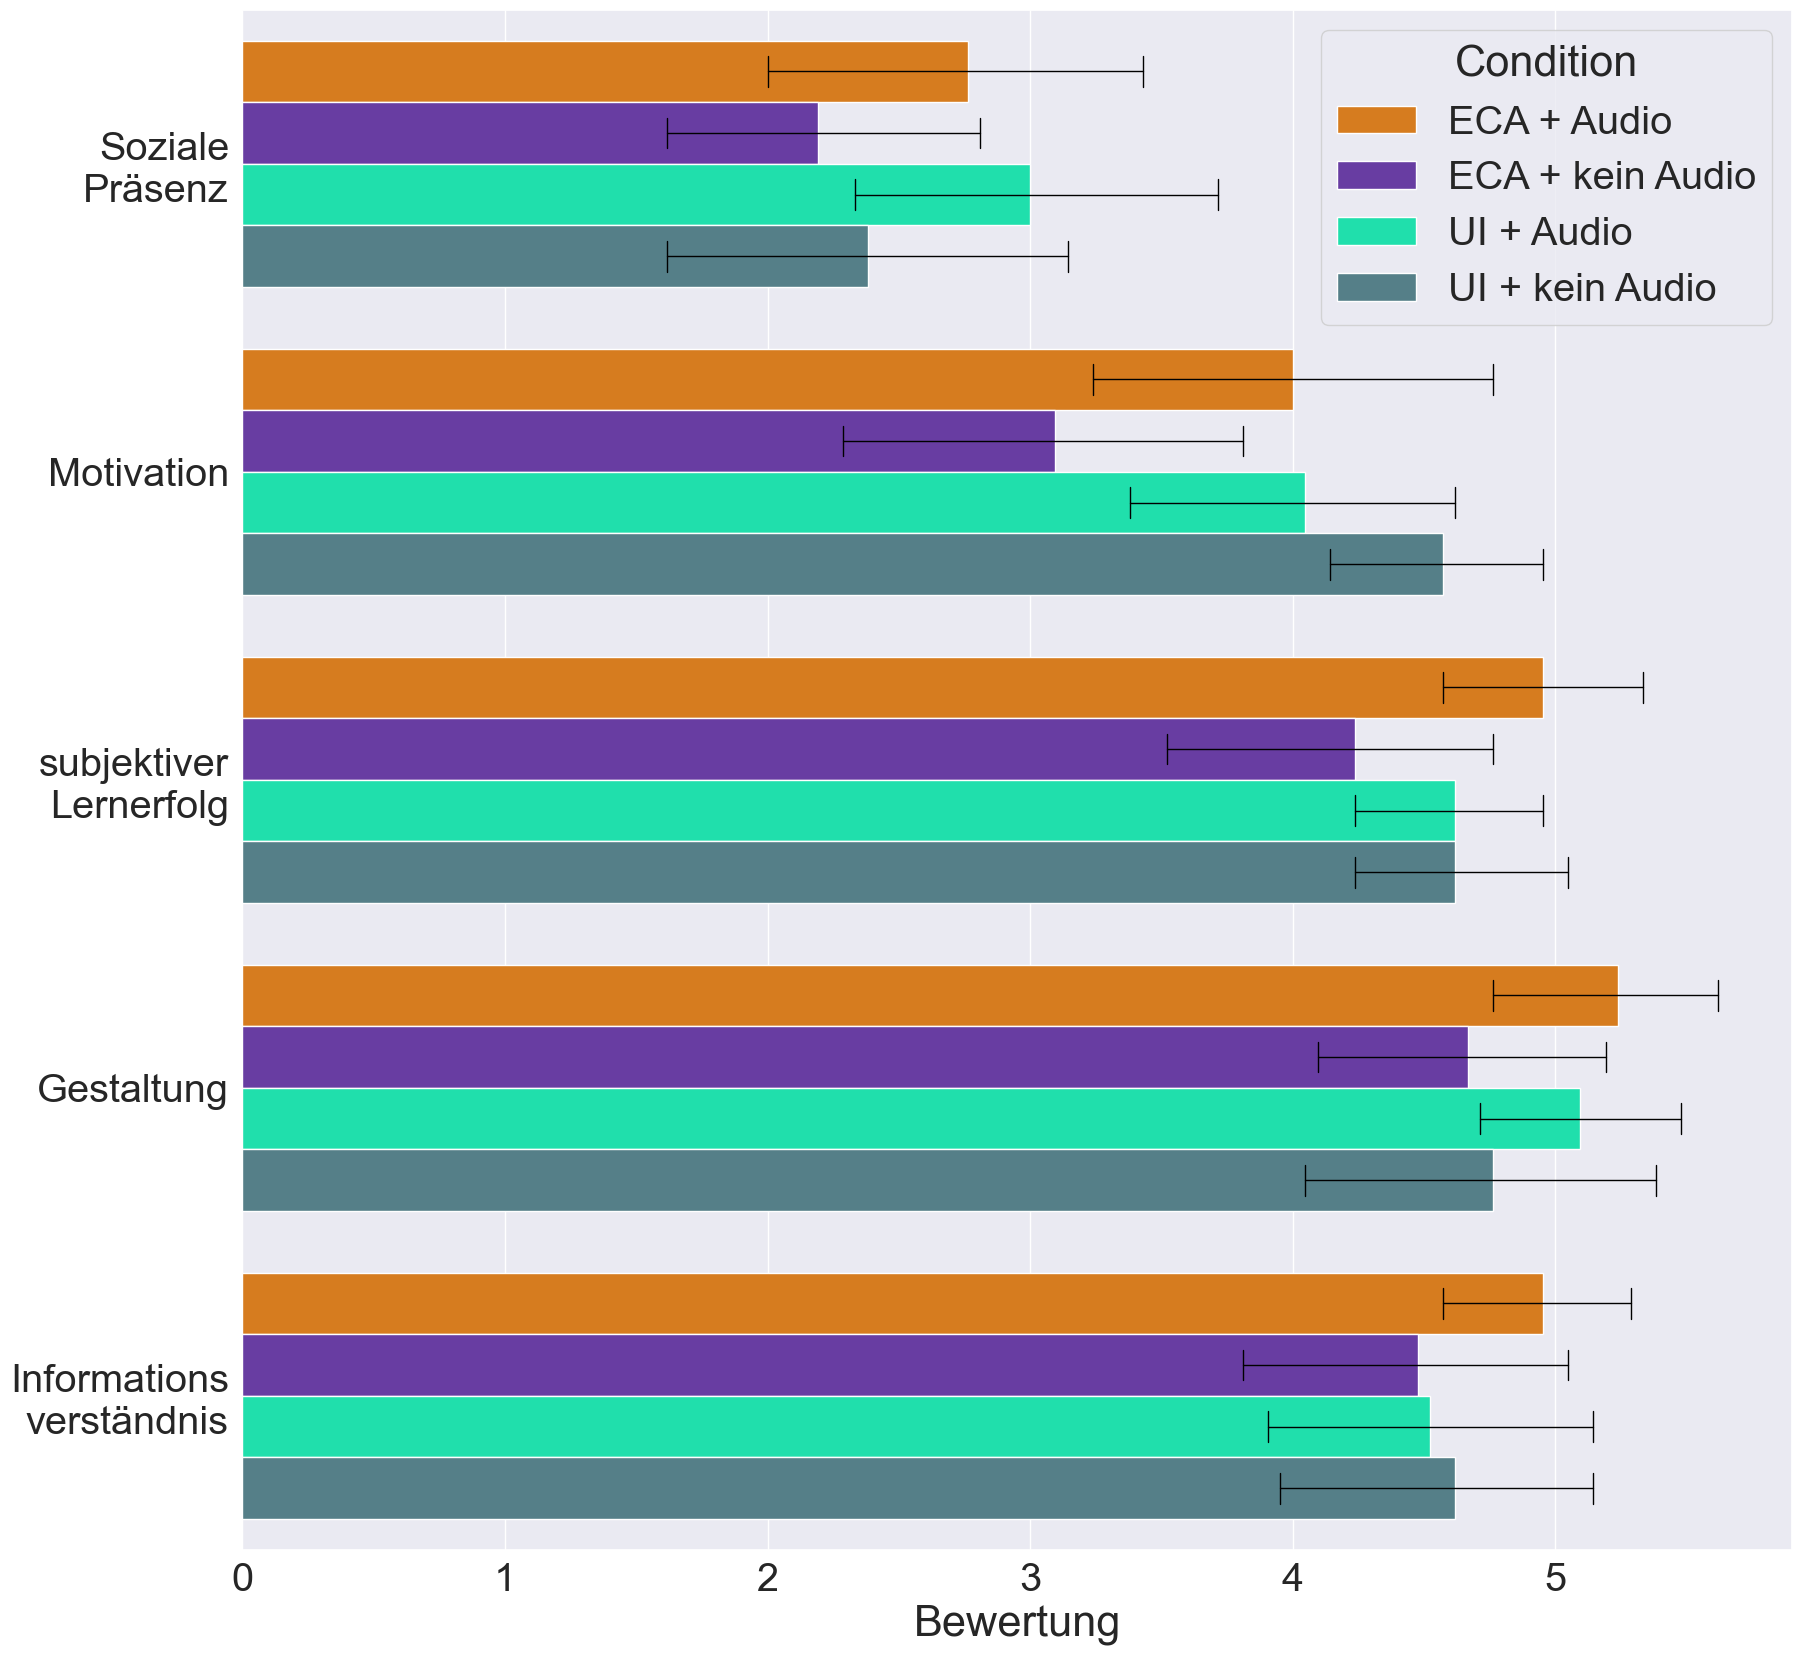

In [15]:
# filter out the variables that are not needed
new_df = long_df.filter(~pl.col("Variable").is_in(["UX_Score", 
                                                   "TestResult", 
                                                    "Effizienz Wertung", 
                                                   "Stimulations Wertung"]))

# order the conditions like that in dataframe order=["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio",],
new_df_pd = new_df.to_pandas()
new_df_pd['Condition'] = pd.Categorical(new_df_pd['Condition'], ["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"])
sns.set(font_scale=2.6)

#wrap labels to avoid overlapping
new_df_pd["Variable"] = new_df_pd["Variable"].str.wrap(12)
# make as barcharts and use mean and std as error bars
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", 
            y="Variable", 
            hue="Condition", 
            data=new_df_pd, 
            palette=my_pal,
            capsize=.1,
            errwidth=1,
            errcolor="black",
            )
plt.xlabel("Bewertung")
plt.ylabel("")
plt.show()



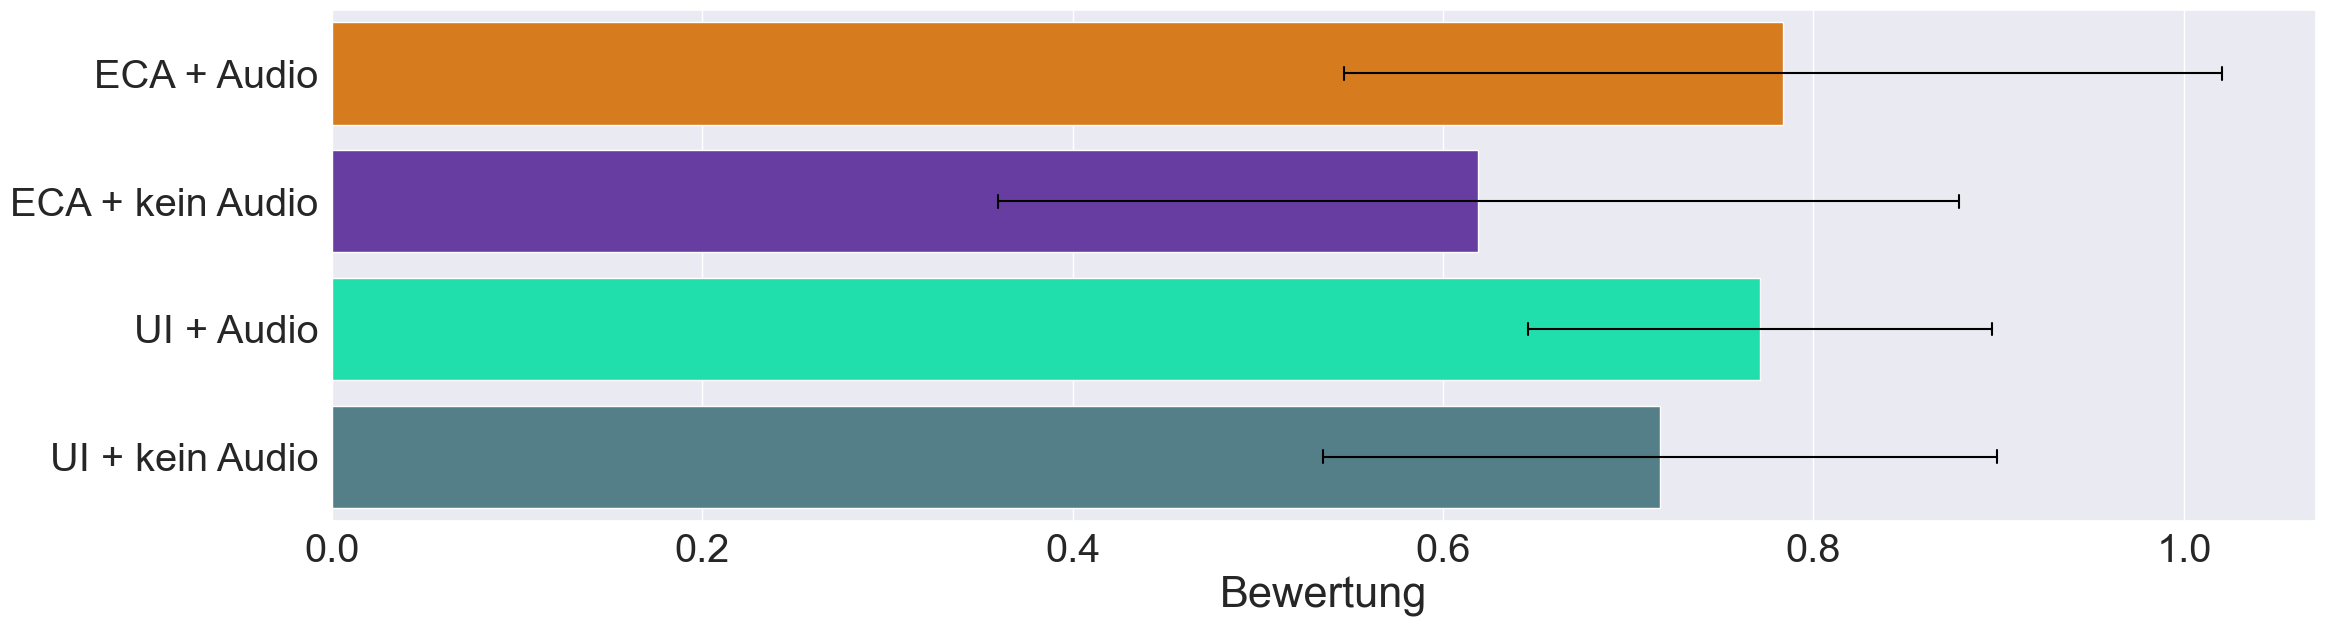

In [16]:
# Filter to show only the UX_Score
filtered_long_df = long_df.filter(pl.col("Variable").is_in(["UX_Score"]))

filtered_long_df_pd = filtered_long_df.to_pandas()


plt.figure(figsize=(24, 7
                    ))
ax = sns.barplot(
    data=filtered_long_df_pd,
    x="Value", 
    y="Condition",
    #hue="Condition",
    palette=my_pal,
    order=["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"],
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()


# print a table with the statistics
#print(tabulate(stats_df_pd_all, headers='keys', tablefmt='psql'))

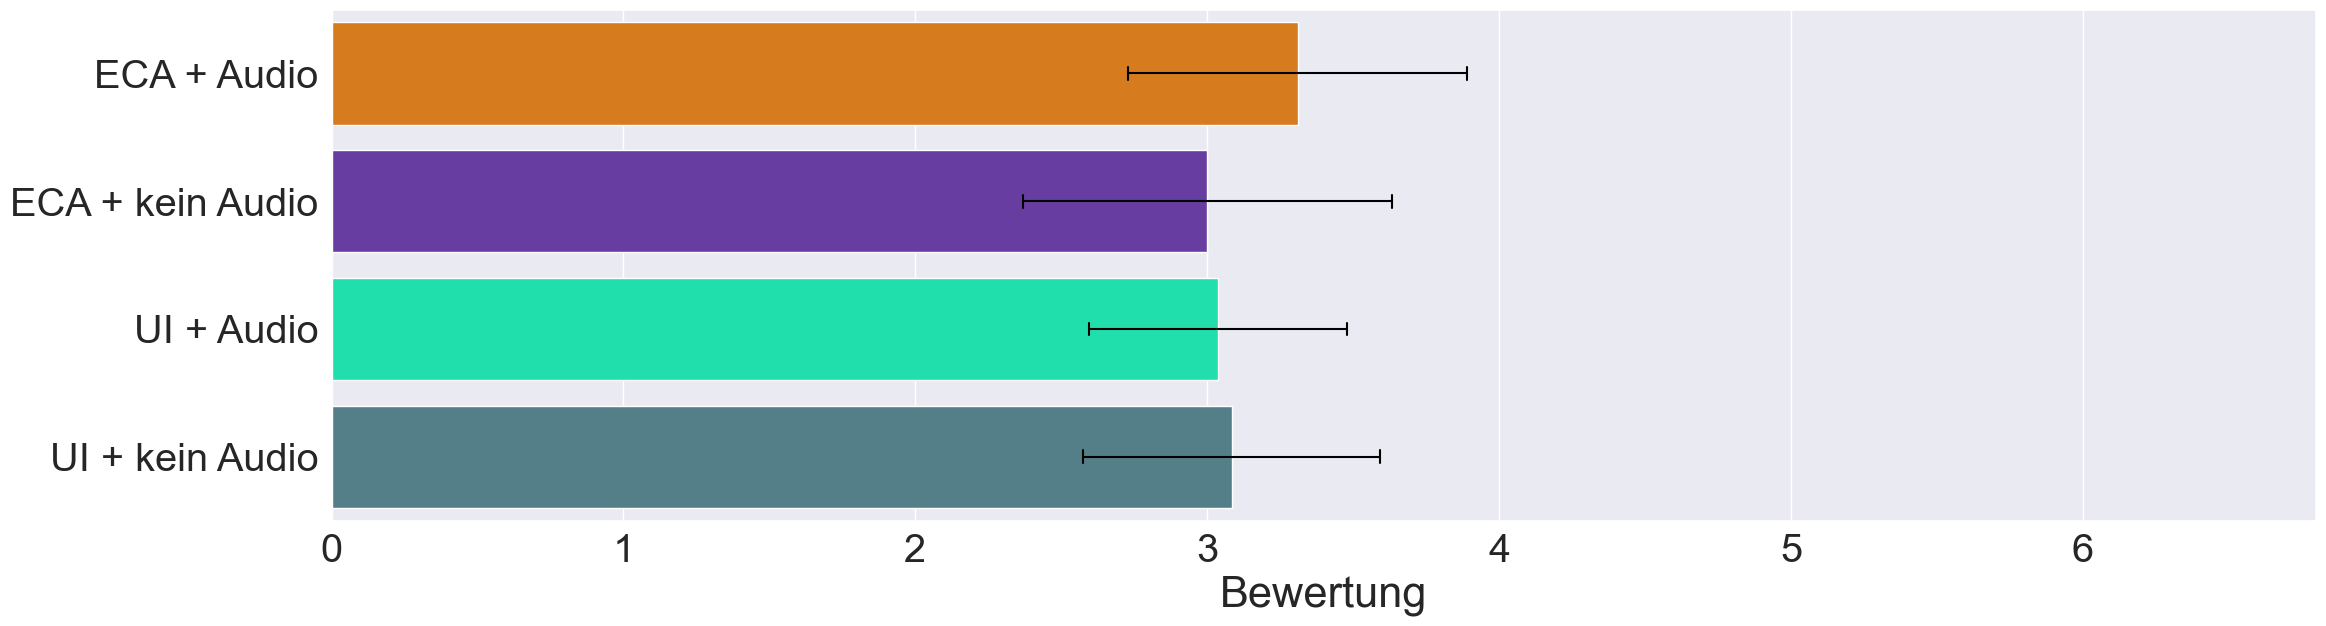

In [17]:
# Filter to show only the Effizienz Wertung
filtered_long_df = long_df.filter(pl.col("Variable").is_in(["Effizienz Wertung"]))

# make sure x axis has always values from 0 to 6
plt.figure(figsize=(24, 7))
sns.barplot(
    data=filtered_long_df.to_pandas(),
    x="Value", 
    y="Condition",
    #hue="Condition",
    palette=my_pal,
    order=["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"],
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 6.8)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()

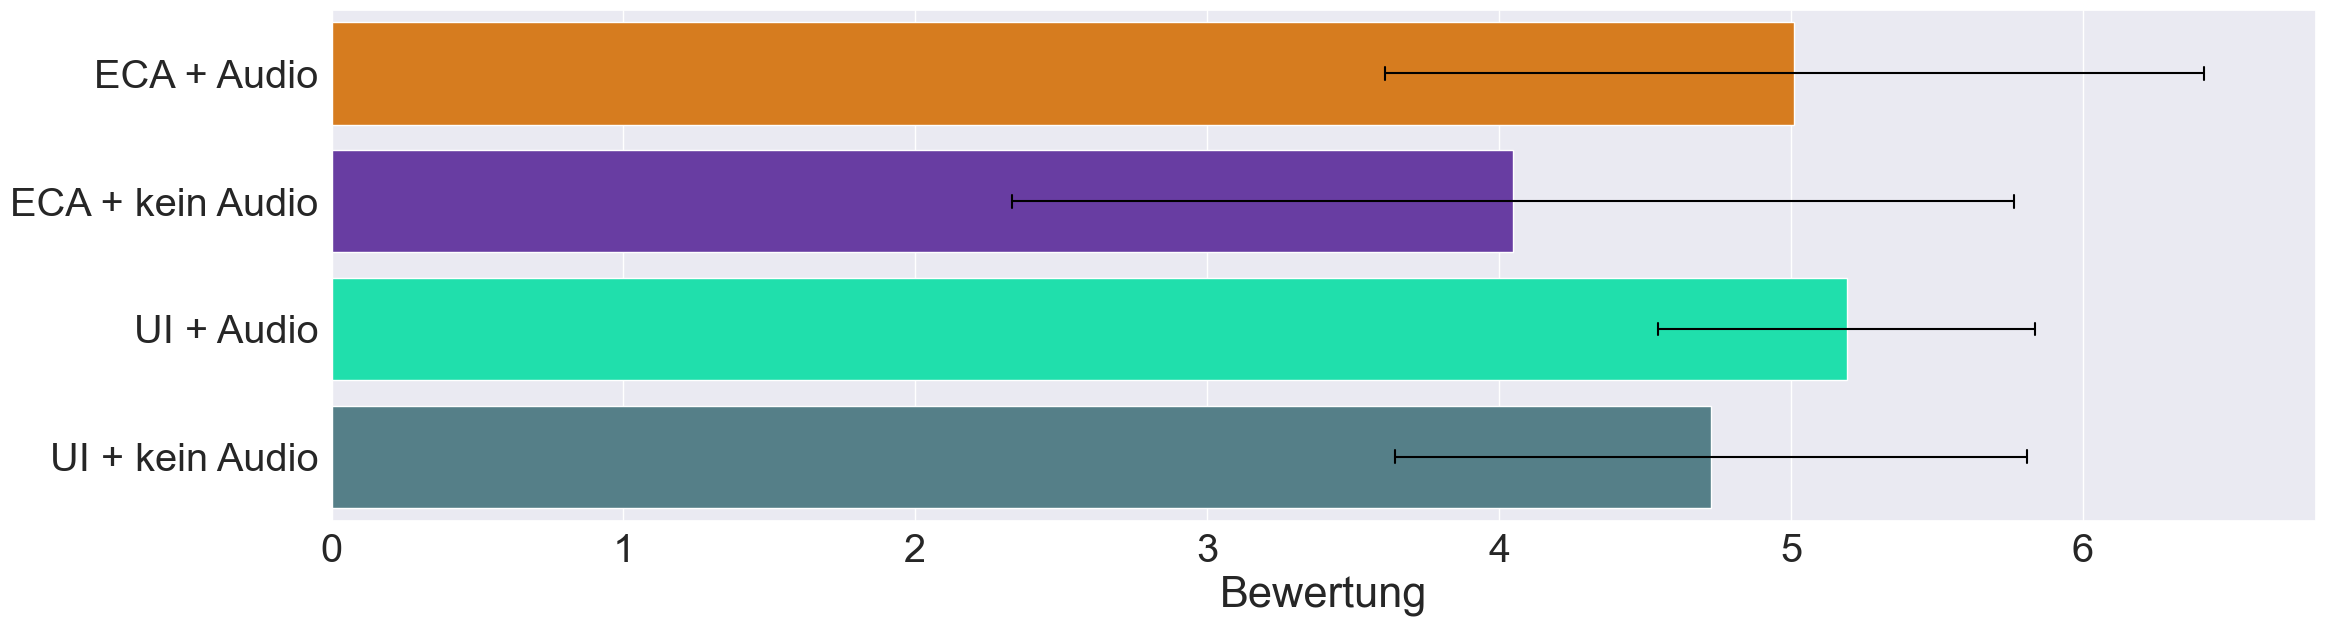

In [18]:
# Filter to show only the Stimulations Wertung
filtered_long_df = long_df.filter(pl.col("Variable").is_in(["Stimulations Wertung"]))

plt.figure(figsize=(24, 7))
sns.barplot(
    data=filtered_long_df.to_pandas(),
    x="Value", 
    y="Condition",
    #hue="Condition",
    palette=my_pal,
    order=["ECA + Audio","ECA + kein Audio", "UI + Audio", "UI + kein Audio", ],
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 6.8)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [19]:
# Define combined conditions
combined_conditions_interface = {
    "ECA": ["ECA + Audio", "ECA + kein Audio"],
    "UI": ["UI + Audio", "UI + kein Audio"],
}

combined_conditions_Audio = {
    "Audio": ["ECA + Audio", "UI + Audio"],
    "Kein Audio": ["ECA + kein Audio", "UI + kein Audio"]
}   

# map the combined conditions
def map_combined_condition(row):
    for combo_name, cond_list in combined_conditions_interface.items():
        if row["Condition"] in cond_list:
            return combo_name
    return row["Condition"]

def map_combined_condition_Audio(row):
    for combo_name, cond_list in combined_conditions_Audio.items():
        if row["Condition"] in cond_list:
            return combo_name
    return row["Condition"]

### Jetzt werden die Kombinierten Bedingungen (Interface und Modalität) angeschaut

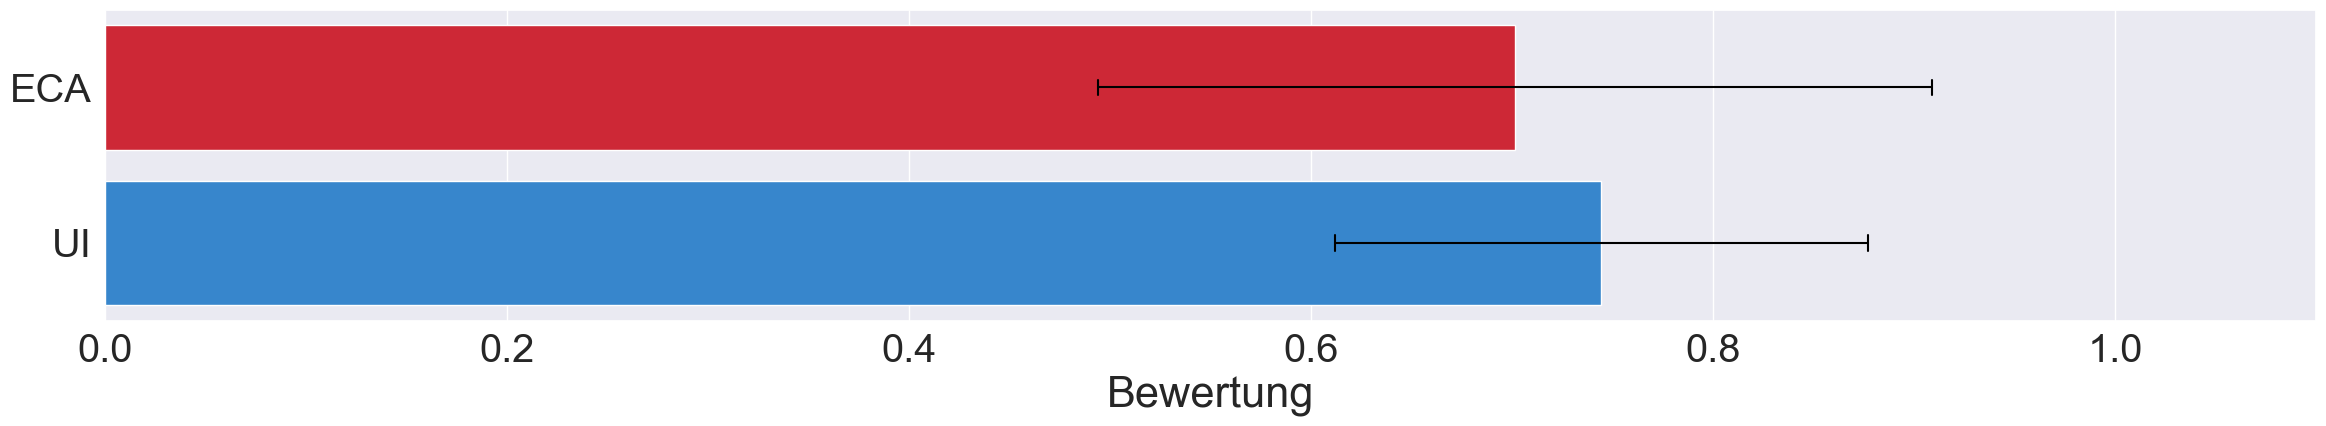

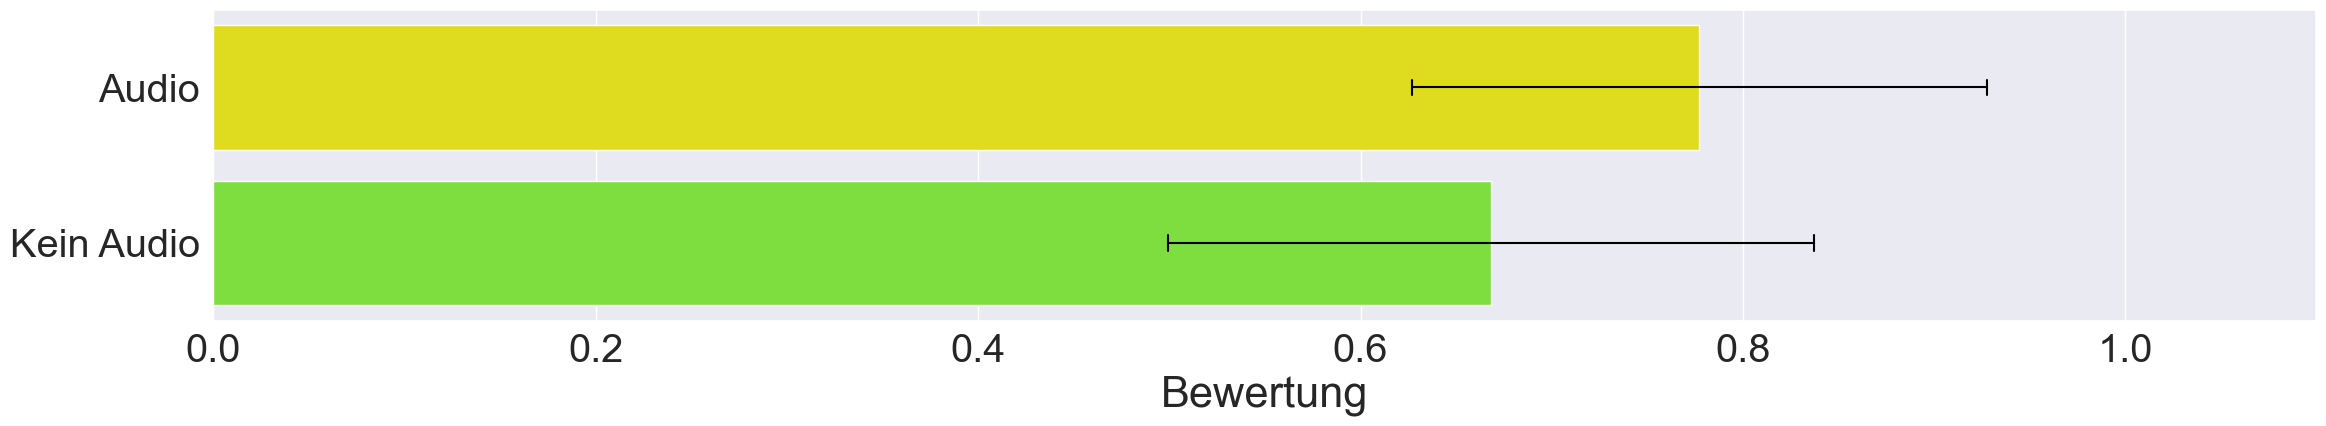

In [20]:
filtered_long_df = long_df.filter(pl.col("Variable").is_in(["UX_Score"]))

filtered_long_df_pd = filtered_long_df.to_pandas()
interface_combined = filtered_long_df_pd.copy()
interface_combined["Combined_Condition"] = filtered_long_df_pd.apply(map_combined_condition, axis=1)
# select only the relevant columns
interface_combined = interface_combined[["PersonID", "Combined_Condition", "Value"]]
interface_combined = interface_combined.groupby(["PersonID", "Combined_Condition"]).agg({"Value": "mean"}).reset_index()


plt.figure(figsize=(24, 5))
sns.barplot(
    data=interface_combined,
    x="Value",
    y="Combined_Condition",
    #hue="Combined_Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 1.1)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()


Audio_combined = filtered_long_df_pd.copy()
Audio_combined["Combined_Condition"] = filtered_long_df_pd.apply(map_combined_condition_Audio, axis=1)
# select only the relevant columns
Audio_combined = Audio_combined[["PersonID", "Combined_Condition", "Value"]]
Audio_combined = Audio_combined.groupby(["PersonID", "Combined_Condition"]).agg({"Value": "mean"}).reset_index()


plt.figure(figsize=(24, 5))
sns.barplot(
    data=Audio_combined,
    x="Value",
    y="Combined_Condition",
    #hue="Combined_Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 1.1)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()


### Lernergebnis

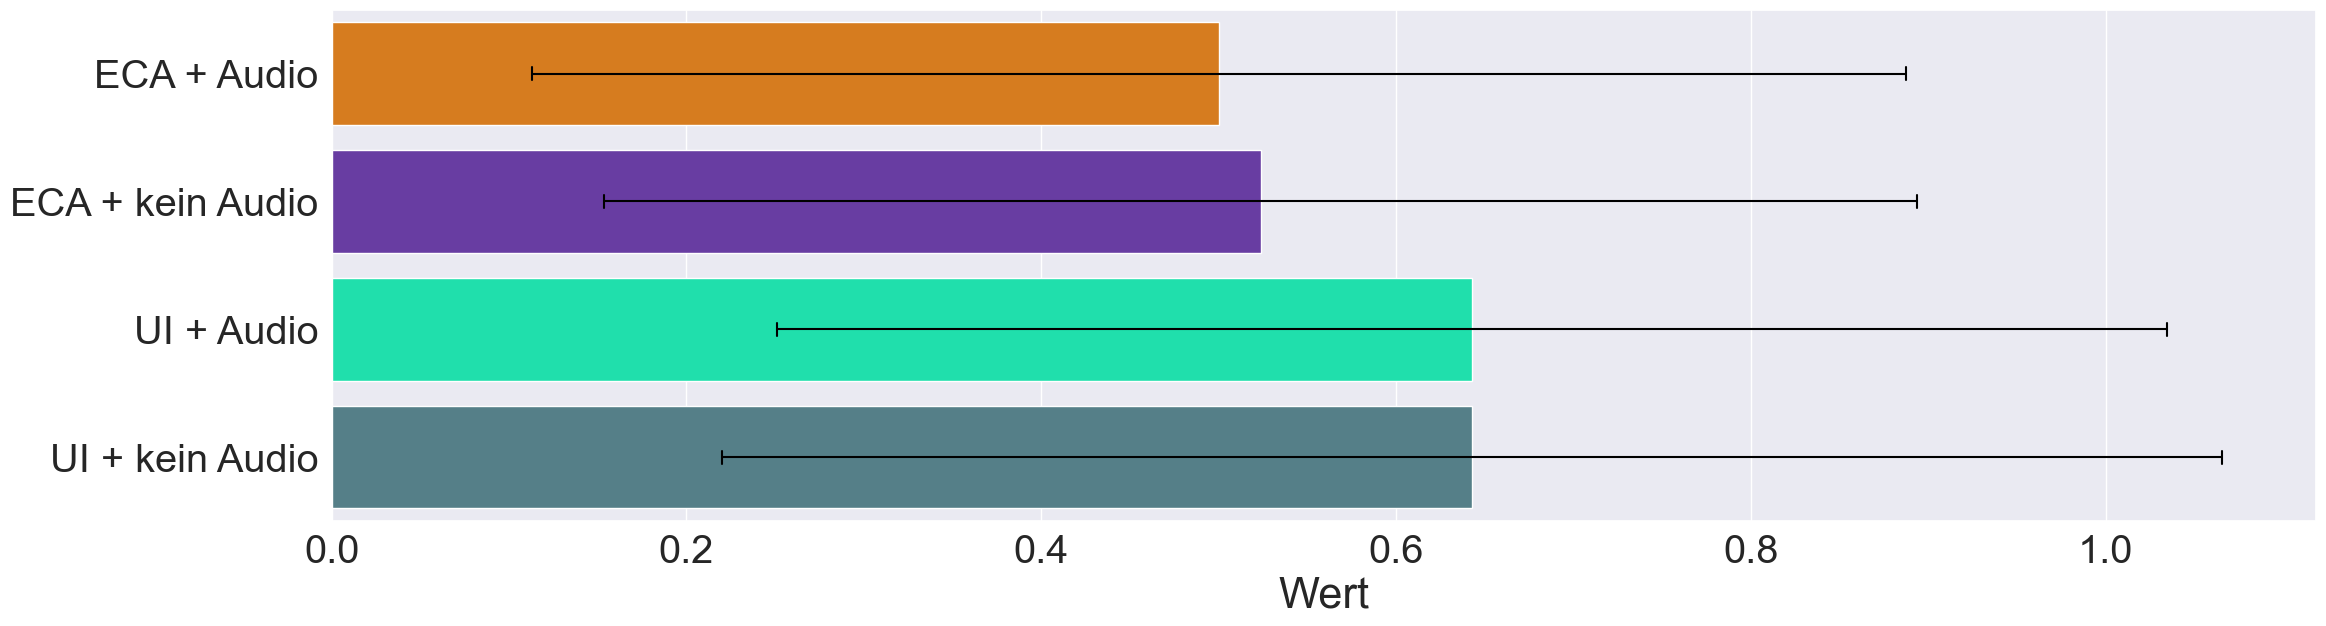

In [21]:
filtered_long_df_testResult = long_df.filter(pl.col("Variable").is_in(["TestResult"]))
# make bar chart for TestResult
plt.figure(figsize=(24, 7))
sns.barplot(
    data=filtered_long_df_testResult.to_pandas(),
    x="Value",
    y="Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
    order=["ECA + Audio", "ECA + kein Audio", "UI + Audio", "UI + kein Audio"],
)
plt.xlabel("Wert")
plt.ylabel("")
plt.tight_layout()
plt.show()

### Kombinierte Bedingungen Lernergebis

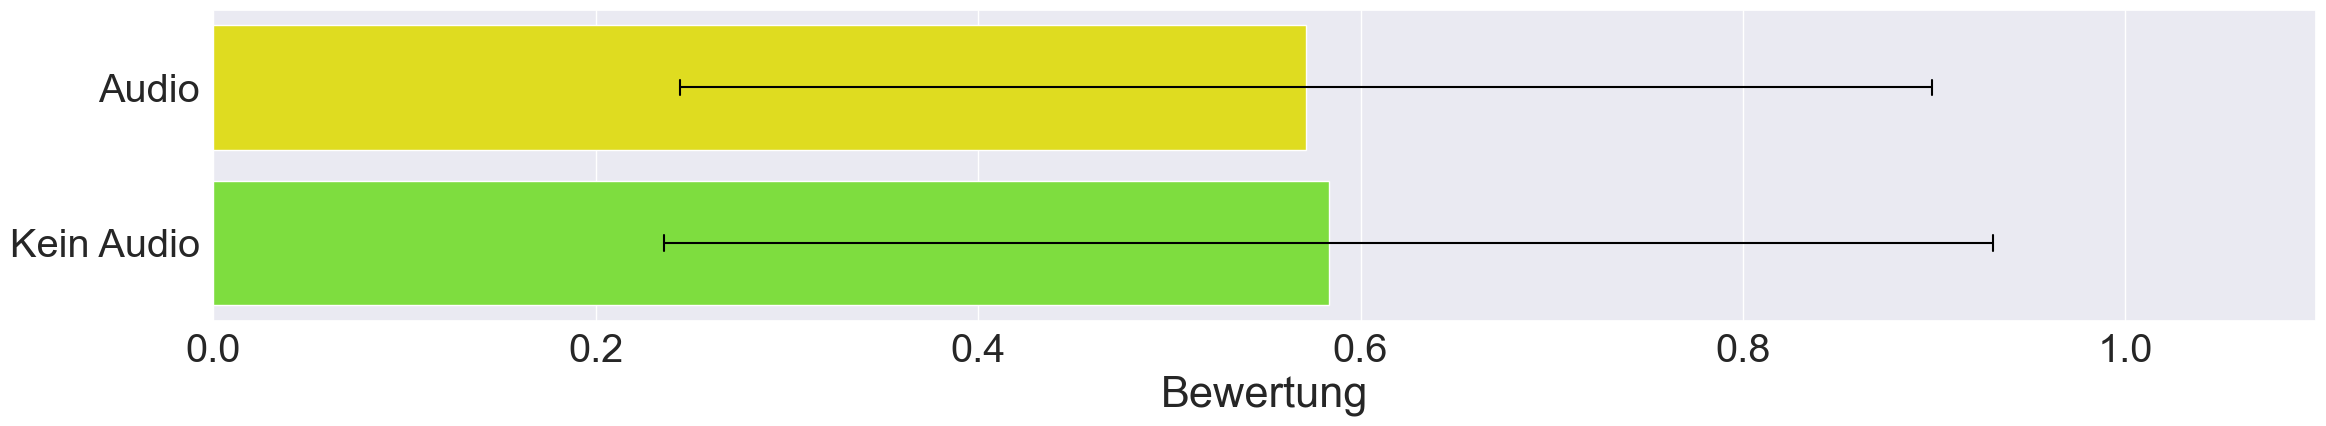

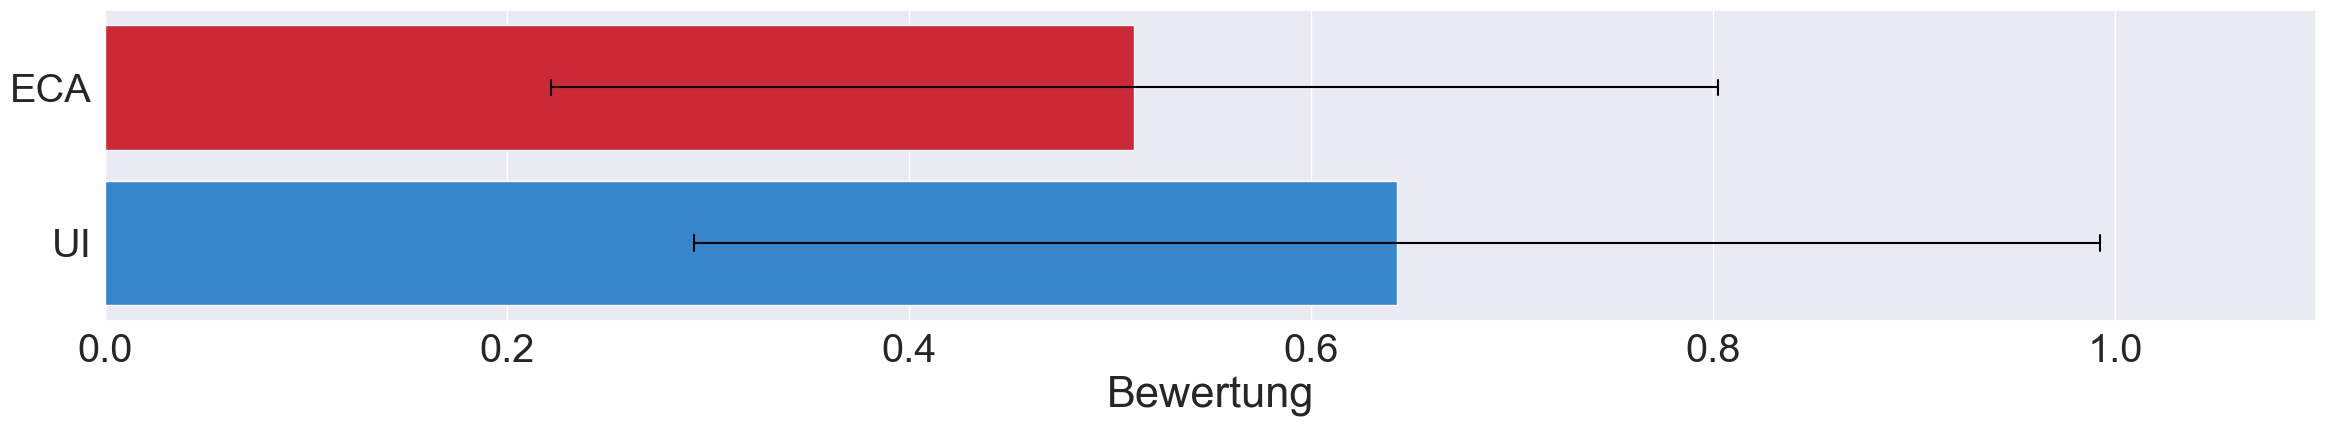

In [22]:
Audio_combined_testResult = filtered_long_df_testResult.to_pandas().copy()
Audio_combined_testResult["Combined_Condition"] = Audio_combined_testResult.apply(map_combined_condition_Audio, axis=1)

# select only the relevant columns
Audio_combined_testResult = Audio_combined_testResult[["PersonID", "Combined_Condition", "Value"]]
Audio_combined_testResult = Audio_combined_testResult.groupby(["PersonID", "Combined_Condition"]).agg({"Value": "mean"}).reset_index()

plt.figure(figsize=(24, 5))
sns.barplot(
    data=Audio_combined_testResult,
    x="Value",
    y="Combined_Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 1.1)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()

plt.show()

interface_combined_testResult = filtered_long_df_testResult.to_pandas().copy()
interface_combined_testResult["Combined_Condition"] = interface_combined_testResult.apply(map_combined_condition, axis=1)
# select only the relevant columns
interface_combined_testResult = interface_combined_testResult[["PersonID", "Combined_Condition", "Value"]]
interface_combined_testResult = interface_combined_testResult.groupby(["PersonID", "Combined_Condition"]).agg({"Value": "mean"}).reset_index()
# make bar chart for combined conditions
plt.figure(figsize=(24,5 ))
sns.barplot(
    data=interface_combined_testResult,
    x="Value",
    y="Combined_Condition",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlim(0, 1.1)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.tight_layout()
plt.show()

### Passend die Präferenzen zu den besseren Lernergebnissen?

In [23]:
# split the data into the ECA and UI conditions
fav_combined = fav.to_pandas()
fav_combined["Favorite Condition"] = fav_combined["Condition"].apply(lambda x: "ECA" if x == "ECA + Audio" else "UI")
fav_combined = fav_combined[["PersonID", "Favorite Condition"]]

df_wide = interface_combined_testResult.pivot(
    index="PersonID", 
    columns="Combined_Condition", 
    values="Value"
)

df_wide.head()

# join with test result data
pref = fav_combined.groupby('PersonID')['Favorite Condition'].first()
df_wide = df_wide.join(pref, on='PersonID', how='inner')

df_wide.head()
df_wide["Diff_UI_minus_ECA"] = df_wide["UI"] - df_wide["ECA"]


In [24]:
def get_better_condition(row):
    if row["Diff_UI_minus_ECA"] > 0:
        return "UI"
    elif row["Diff_UI_minus_ECA"] < 0:
        return "ECA"
    else:
        return "Equal"

df_wide["ActuallyBetter"] = df_wide.apply(get_better_condition, axis=1)

df_wide["PrefMatch"] = (df_wide["Favorite Condition"] == df_wide["ActuallyBetter"])

df_wide["PrefMatch"].value_counts()
pct_match = df_wide["PrefMatch"].mean() * 100
print(f"{pct_match:.2f}% der Teilnehmenden haben die Bedingung bevorzugt, in der sie tatsächlich besser waren.")
df_wide.groupby("Favorite Condition")["Diff_UI_minus_ECA"].describe()

crosstab = pd.crosstab(
    df_wide["Favorite Condition"],   # Zeilen
    df_wide["ActuallyBetter"]       # Spalten
)
print(crosstab)




33.33% der Teilnehmenden haben die Bedingung bevorzugt, in der sie tatsächlich besser waren.
ActuallyBetter      ECA  Equal  UI
Favorite Condition                
ECA                   4      4   8
UI                    0      2   3


### Gesamt UX Bewertung

In [25]:

columns = [col for col in final_ux_scores.columns if col != "PersonID"]


stats = final_ux_scores.select([
    getattr(pl.col(col), agg)().round(2).alias(f"{agg}_{col}")
    for col in columns
    for agg in ["median", "mean", "std"]
])


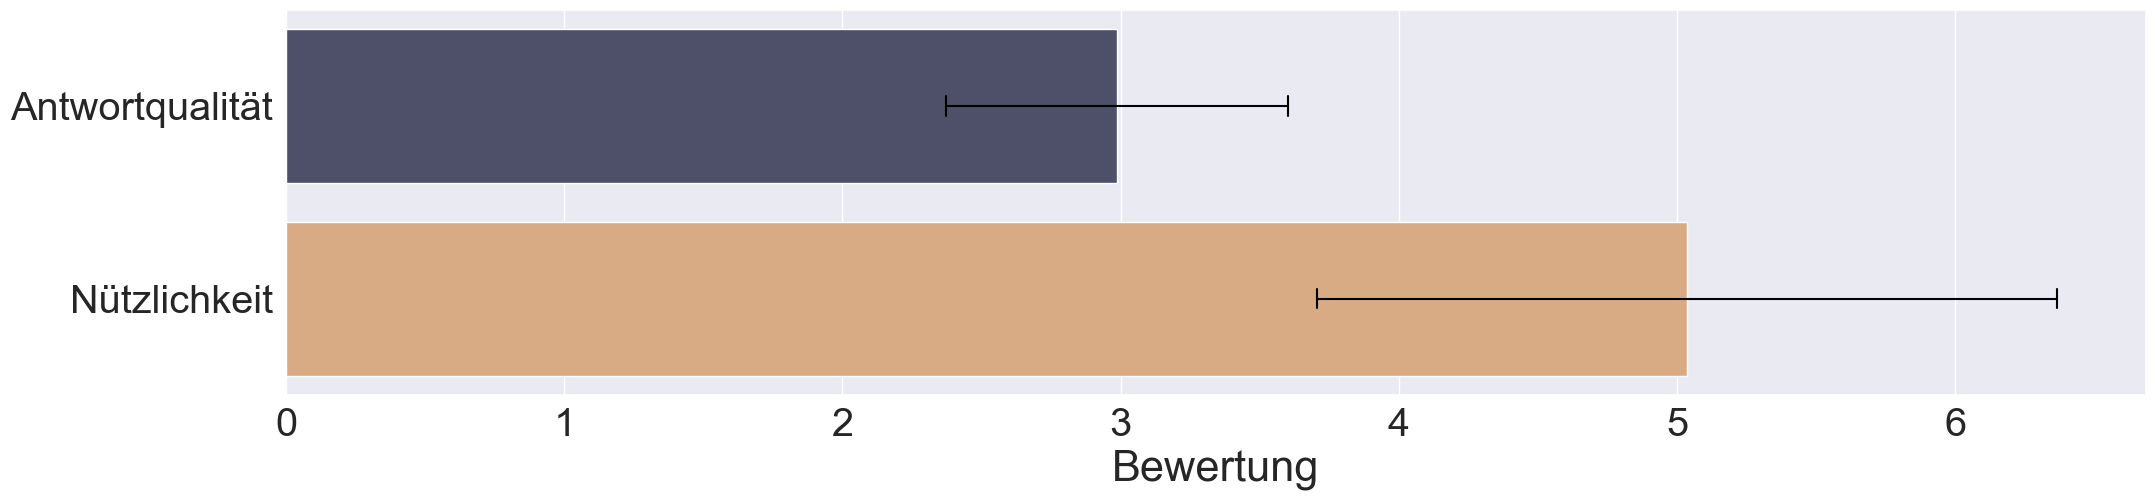

In [26]:
Antwortqualität_pd = Antwortqualität.to_pandas()
Nützlichkeit_pd = Nützlichkeit_df.to_pandas()


Antwortqualität_pd['Score_Type'] = 'Antwortqualität'
Nützlichkeit_pd['Score_Type'] = 'Nützlichkeit'

# Rename columns
Antwortqualität_pd = Antwortqualität_pd.rename(columns={'Antwortqualität': 'Score'})
Nützlichkeit_pd = Nützlichkeit_pd.rename(columns={'Nützlichkeit': 'Score'})

# KCombining the two dataframes
combined_scores = pd.concat([Antwortqualität_pd, Nützlichkeit_pd])



plt.figure(figsize=(24,5))
sns.barplot(
    data=combined_scores,
    x="Score",
    y="Score_Type",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.show()


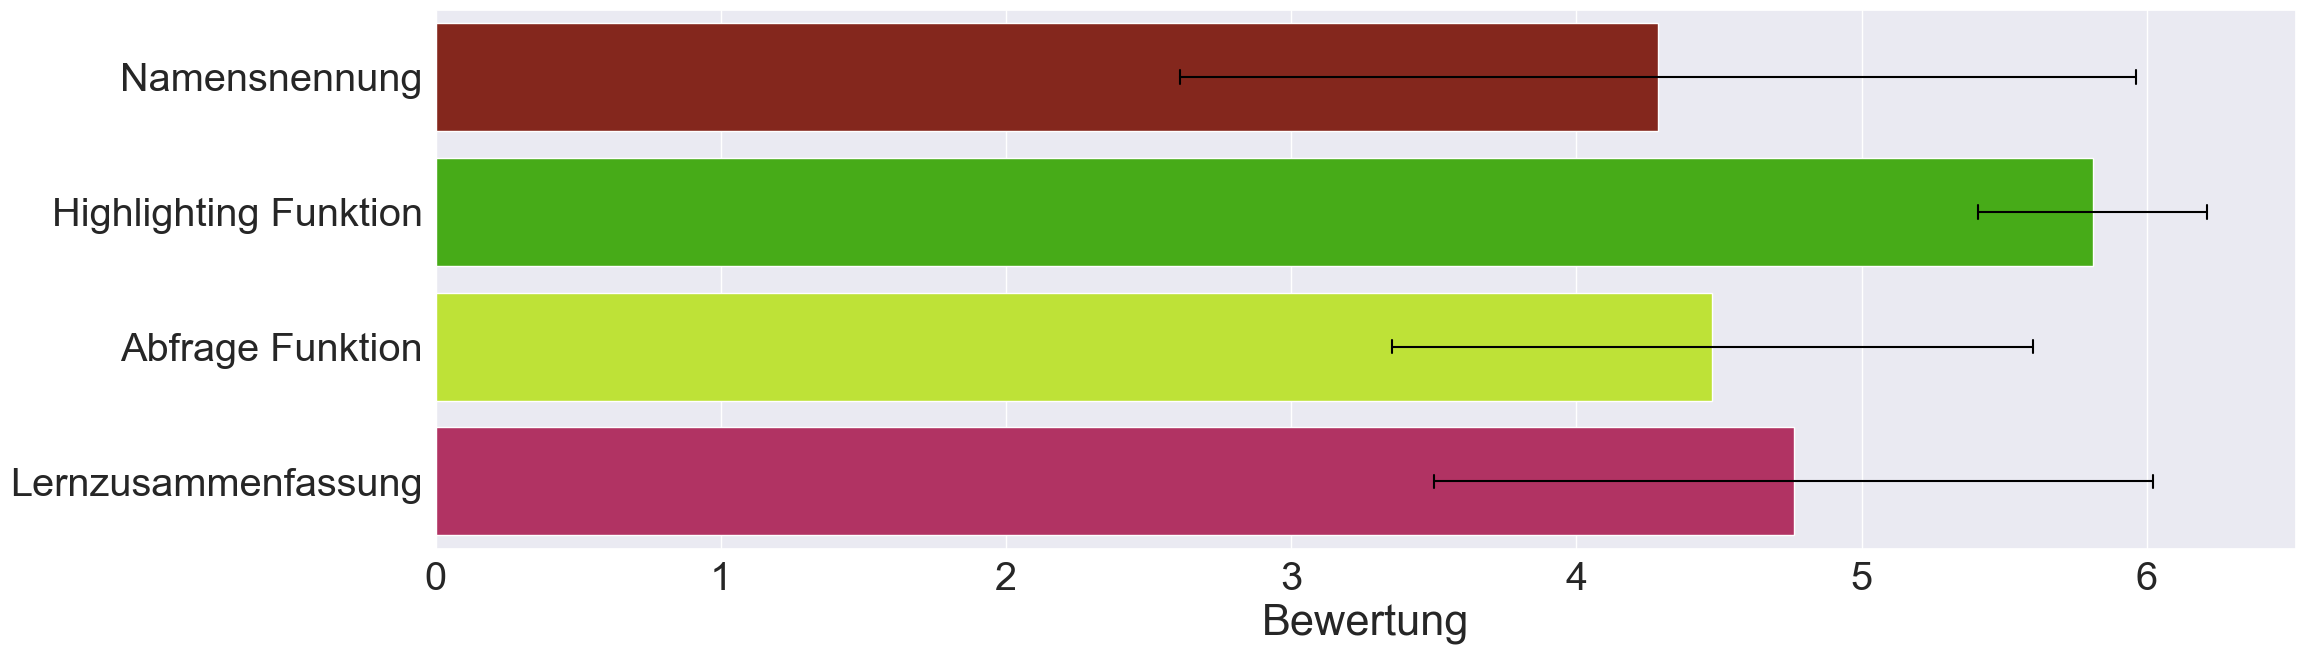

In [27]:
rolle_motivator_score_pd = Rolle_Motivator_score.to_pandas()
rolle_organisator_score_pd = Rolle_Organisator_score.to_pandas()
rolle_tutor_score_pd = Rolle_Tutor_score.to_pandas()
rolle_tutor2_score_pd = Rolle_Tutor2_score.to_pandas()

rolle_motivator_score_pd['Score_Type'] = 'Namensnennung'
rolle_organisator_score_pd['Score_Type'] = 'Highlighting Funktion'
rolle_tutor_score_pd['Score_Type'] = 'Abfrage Funktion'
rolle_tutor2_score_pd['Score_Type'] = 'Lernzusammenfassung'

rolle_motivator_score_pd = rolle_motivator_score_pd.rename(columns={'Rolle_Motivator_Score': 'Score'})
rolle_organisator_score_pd = rolle_organisator_score_pd.rename(columns={'Rolle_Organisator_Score': 'Score'})
rolle_tutor_score_pd = rolle_tutor_score_pd.rename(columns={'Rolle_Tutor_Score': 'Score'})
rolle_tutor2_score_pd = rolle_tutor2_score_pd.rename(columns={'Rolle_Tutor2_Score': 'Score'})

combined_scores = pd.concat([rolle_motivator_score_pd, rolle_organisator_score_pd, rolle_tutor_score_pd, rolle_tutor2_score_pd])

plt.figure(figsize=(24, 7))
sns.barplot(
    data=combined_scores,
    x="Score",
    y="Score_Type",
    palette=my_pal,
    errorbar="sd",
    capsize=.1,
    errwidth=1.5,
    errcolor="black",
)
plt.xlabel("Bewertung")
plt.ylabel("")
plt.show()

In [28]:
fav = fav.to_pandas()

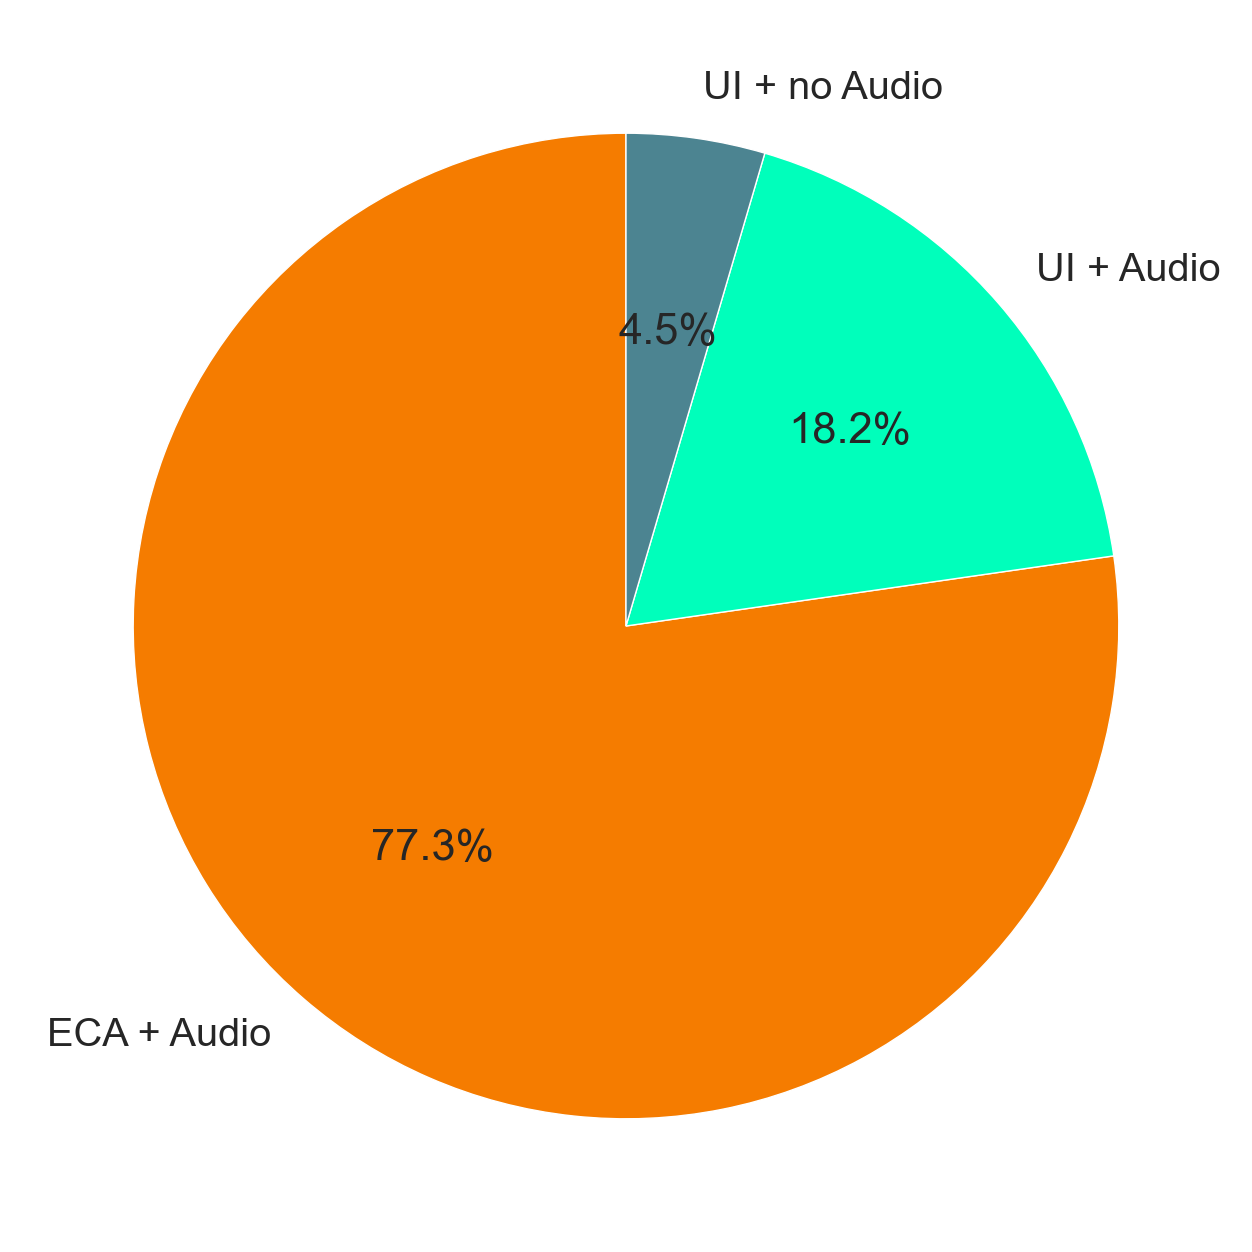

In [29]:

data = fav["Condition"].value_counts()
labels = data.index

plt.figure(figsize=(16, 16))
plt.pie(data, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=90,
        colors=["#F57C00", "#00FFBB", "#4C8491"])
plt.show()



## Signifikanztests

### ECA und UI und Lernerfolg

#### Daten vorbereiten

In [30]:
agg_df = learning_results.group_by(['PersonID', 'Condition']).agg([
    pl.mean("TestResult").alias("TestResult"),
])


eval_data = (
    agg_df.select("PersonID", "Condition", "TestResult")
    .with_columns(
        Audio=pl.when(pl.col("Condition").str.contains("kein Audio"))
        .then(pl.lit("kein Audio"))
        .otherwise(pl.lit("Audio")),
        Interface=pl.when(pl.col("Condition").str.contains("UI"))
        .then(pl.lit("UI"))
        .otherwise(pl.lit("ECA")),
    )
    .drop("Condition")
)
df_model = eval_data.with_columns(
    Audio_No_Audio=pl.when(pl.col("Audio").eq("kein Audio")).then(1).otherwise(0),
    Interface_UI=pl.when(pl.col("Interface").eq("UI")).then(1).otherwise(0),
).to_pandas()


### Wilkoxon-Vorzeichen-Rang-Test für Interface und Lernerfolg

In [31]:
df_aggregated = df_model.groupby(["PersonID", "Interface"]).agg({"TestResult": "sum"}).reset_index()

stat, p = wilcoxon(
    df_aggregated[df_aggregated["Interface"] == "UI"]["TestResult"],
    df_aggregated[df_aggregated["Interface"] == "ECA"]["TestResult"],alternative='two-sided', mode ='auto'
)

print('Ungerichtet Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = wilcoxon(
    df_aggregated[df_aggregated["Interface"] == "UI"]["TestResult"],
    df_aggregated[df_aggregated["Interface"] == "ECA"]["TestResult"],
    alternative='greater', mode ='auto' # 'greater' für gerichtete Hypothese (UI > ECA)
)

print('Gerichtet (UI>ECA) Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = wilcoxon(
    df_aggregated[df_aggregated["Interface"] == "UI"]["TestResult"],
    df_aggregated[df_aggregated["Interface"] == "ECA"]["TestResult"],
    alternative='less', mode ='auto'  # 'greater' für gerichtete Hypothese (UI > ECA)
)

print('Gerichtet (ECA> UI)Statistics=%.3f, p=%.3f' % (stat, p))

Ungerichtet Statistics=26.000, p=0.040
Gerichtet (UI>ECA) Statistics=94.000, p=0.020
Gerichtet (ECA> UI)Statistics=94.000, p=0.980


C:\Users\lusti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


### Audio und Lernerfolg

In [32]:
df_aggregated_Audio = df_model.groupby(["PersonID", "Audio"]).agg({"TestResult": "mean"}).reset_index()
# exact p-value calculations do not work with zeros, so we add 1 to all TestResults
df_aggregated_Audio["TestResult"] = df_aggregated_Audio["TestResult"] + 1
stat, p = wilcoxon(
    df_aggregated_Audio[df_aggregated_Audio["Audio"] == "kein Audio"]["TestResult"], 
    df_aggregated_Audio[df_aggregated_Audio["Audio"] == "Audio"]["TestResult"],
    alternative='greater'  # 'greater' für gerichtete Hypothese (kein Audio > Audio)
)
print('Statistics=%.3f, p=%.2f' % (stat, p))

Statistics=63.500, p=0.42


C:\Users\lusti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


### Zusammenhäge UX und Interface/Audio

In [33]:
eval_data = (
    condition_ux_scores.select("PersonID", "Condition", "Efficiancy_Score", "Stimulation_Score", "Motivation")
    .with_columns(
        Audio=pl.when(pl.col("Condition").str.contains("kein Audio"))
        .then(pl.lit("kein Audio"))
        .otherwise(pl.lit("Audio")),
        Interface=pl.when(pl.col("Condition").str.contains("UI"))
        .then(pl.lit("UI"))
        .otherwise(pl.lit("ECA")),
    )
    .drop("Condition")
)


# make a new colum UX Score and sum up the efficiancy, stimulation and motivation scores for each person
eval_data1 = eval_data.with_columns(
    (pl.col("Efficiancy_Score") + pl.col("Stimulation_Score") + pl.col("Motivation")).alias("UX_Score")
).drop("Efficiancy_Score", "Stimulation_Score", "Motivation")


eval_data3 = eval_data1.group_by("PersonID", "Audio").agg(
    pl.sum("UX_Score").alias("UX_Score")
)

# drop UI 
eval_data4 = eval_data1.filter(pl.col("Interface").eq("UI")).drop("Interface").group_by("PersonID", "Audio").agg(
    pl.sum("UX_Score").alias("UX_Score")
)

df_Audio = eval_data3.to_pandas()
df_ECA_Audio = eval_data4.to_pandas()

### Normalverteilung überprüfen

In [34]:
df_pivot_Audio = df_Audio.pivot(index='PersonID', columns='Audio', values='UX_Score').dropna()
differences_Audio = df_pivot_Audio['Audio'] - df_pivot_Audio['kein Audio']
stat_diff_Audio, p_diff_Audio = shapiro(differences_Audio)
print('Shapiro-Wilk Test für Differenzen (Audio - kein Audio) UX_Score: Statistik=%.3f, p=%.3f' % (stat_diff_Audio, p_diff_Audio))
if p_diff_Audio > 0.05:
    print('Die Differenzen sind normalverteilt')
else:
    print('Die Differenzen sind nicht normalverteilt')



df_pivot_ECA_Audio = df_ECA_Audio.pivot(index='PersonID', columns='Audio', values='UX_Score').dropna()
differences_ECA_Audio = df_pivot_ECA_Audio['Audio'] - df_pivot_ECA_Audio['kein Audio']
stat_diff_ECA_Audio, p_diff_ECA_Audio = shapiro(differences_ECA_Audio)
print('Shapiro-Wilk Test für Differenzen (ECA Audio - ECA kein Audio) UX_Score: Statistik=%.3f, p=%.3f' % (stat_diff_ECA_Audio, p_diff_ECA_Audio))
if p_diff_ECA_Audio > 0.05:
    print('Die Differenzen sind normalverteilt')
else:
    print('Die Differenzen sind nicht normalverteilt')


Shapiro-Wilk Test für Differenzen (Audio - kein Audio) UX_Score: Statistik=0.972, p=0.787
Die Differenzen sind normalverteilt
Shapiro-Wilk Test für Differenzen (ECA Audio - ECA kein Audio) UX_Score: Statistik=0.963, p=0.583
Die Differenzen sind normalverteilt


In [35]:
Audio_df = df_Audio[df_Audio['Audio'] == 'Audio'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'Audio_UX_Score'})
no_Audio_df = df_Audio[df_Audio['Audio'] == 'kein Audio'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'No_Audio_UX_Score'})

eca_Audio_df = df_ECA_Audio[df_ECA_Audio['Audio'] == 'Audio'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'ECA_Audio_UX_Score'})
eca_no_Audio_df = df_ECA_Audio[df_ECA_Audio['Audio'] == 'kein Audio'][['PersonID', 'UX_Score']].rename(columns={'UX_Score': 'ECA_No_Audio_UX_Score'})


### TTest für Audio und UX

In [36]:
stat_t, p_t = ttest_rel(no_Audio_df['No_Audio_UX_Score'], Audio_df['Audio_UX_Score'], alternative='less')
print('Gerichteter t-Test für Audio > kein Audio: Statistik=%.3f, p=%.3f' % (stat_t, p_t))
if p_t < 0.05:
    print('Signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird verworfen)')
else:
    print('Kein signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird nicht verworfen)')


Gerichteter t-Test für Audio > kein Audio: Statistik=-2.182, p=0.021
Signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird verworfen)


### TTest für ECA Audio und ECA kein Audio und UX

In [37]:
stat_t, p_t = ttest_rel(eca_no_Audio_df['ECA_No_Audio_UX_Score'], eca_Audio_df['ECA_Audio_UX_Score'], alternative='less')
print('Gerichteter t-Test für ECA kein Audio < ECA Audio: Statistik=%.3f, p=%.2f' % (stat_t, p_t))
if p_t < 0.05:
    print('Signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird verworfen)')
else:
    print('Kein signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird nicht verworfen)')
    

Gerichteter t-Test für ECA kein Audio < ECA Audio: Statistik=-0.720, p=0.24
Kein signifikanter Unterschied zwischen Audio und kein Audio UX_Scores (H0 wird nicht verworfen)


## Gewichtete Fehlerrate

In [38]:
# Count if in the Testresults specific components are more often wrong than ot
df_post_false = question_results.filter(pl.col("TestResult").eq("false"))
print(df_post_false)
df_post_false.to_pandas()

counts_wrong = (
    df_post_false
    .group_by("CorrectComponent")
    .agg(pl.count("CorrectComponent").alias("Fehlversuche"))
    .sort("Fehlversuche")
    .to_pandas()
)

print(counts_wrong)




shape: (70, 5)
┌──────────┬───────────────┬────────────┬──────────────────┬───────────────────┐
│ PersonID ┆ TestCondition ┆ TestResult ┆ CorrectComponent ┆ SelectedComponent │
│ ---      ┆ ---           ┆ ---        ┆ ---              ┆ ---               │
│ i64      ┆ str           ┆ bool       ┆ i64              ┆ i64               │
╞══════════╪═══════════════╪════════════╪══════════════════╪═══════════════════╡
│ 16       ┆ PostTest      ┆ false      ┆ 14               ┆ 15                │
│ 4        ┆ PostTest      ┆ false      ┆ 14               ┆ -2                │
│ 21       ┆ PostTest      ┆ false      ┆ 26               ┆ -2                │
│ 9        ┆ PostTest      ┆ false      ┆ 21               ┆ 12                │
│ 8        ┆ PostTest      ┆ false      ┆ 15               ┆ 19                │
│ …        ┆ …             ┆ …          ┆ …                ┆ …                 │
│ 19       ┆ PostTest      ┆ false      ┆ 21               ┆ 19                │
│ 9        ┆ 

In [39]:
# How often was each component asked
df_post_total = (
    question_results
    .group_by("CorrectComponent")
    .agg(pl.count("CorrectComponent").alias("Gesamt"))
    .sort("Gesamt")
    .to_pandas()
)

df_merged = pd.merge(counts_wrong, df_post_total, on="CorrectComponent", how="outer").fillna(0)

df_merged["Fehlerrate"] = df_merged["Fehlversuche"] / df_merged["Gesamt"]
df_merged = df_merged.sort_values(by="Fehlerrate", ascending=False)

In [40]:
counts_cond = (
    test_condition_orders_exploded
    .group_by( "Condition", "Component")
    .agg(pl.count("Component").alias("Count"))
    .sort("Count")
    .to_pandas()
)

counts_total = (
    test_condition_orders_exploded
    .group_by("Component")
    .agg(pl.count("Component").alias("Total"))
    .sort("Total")
    .to_pandas()
)


df_cond_total = pd.merge(
    counts_cond, 
    counts_total, 
    on="Component", 
    how="left")


#rename CorrectComponent to Component
df_merged = df_merged.rename(columns={"CorrectComponent": "Component"})

df_final = pd.merge(
    df_cond_total, 
    df_merged, 
    on="Component", 
    how="left")

df_final = df_final.fillna(0)

df_final = df_final.sort_values(by="Condition", ascending=True)


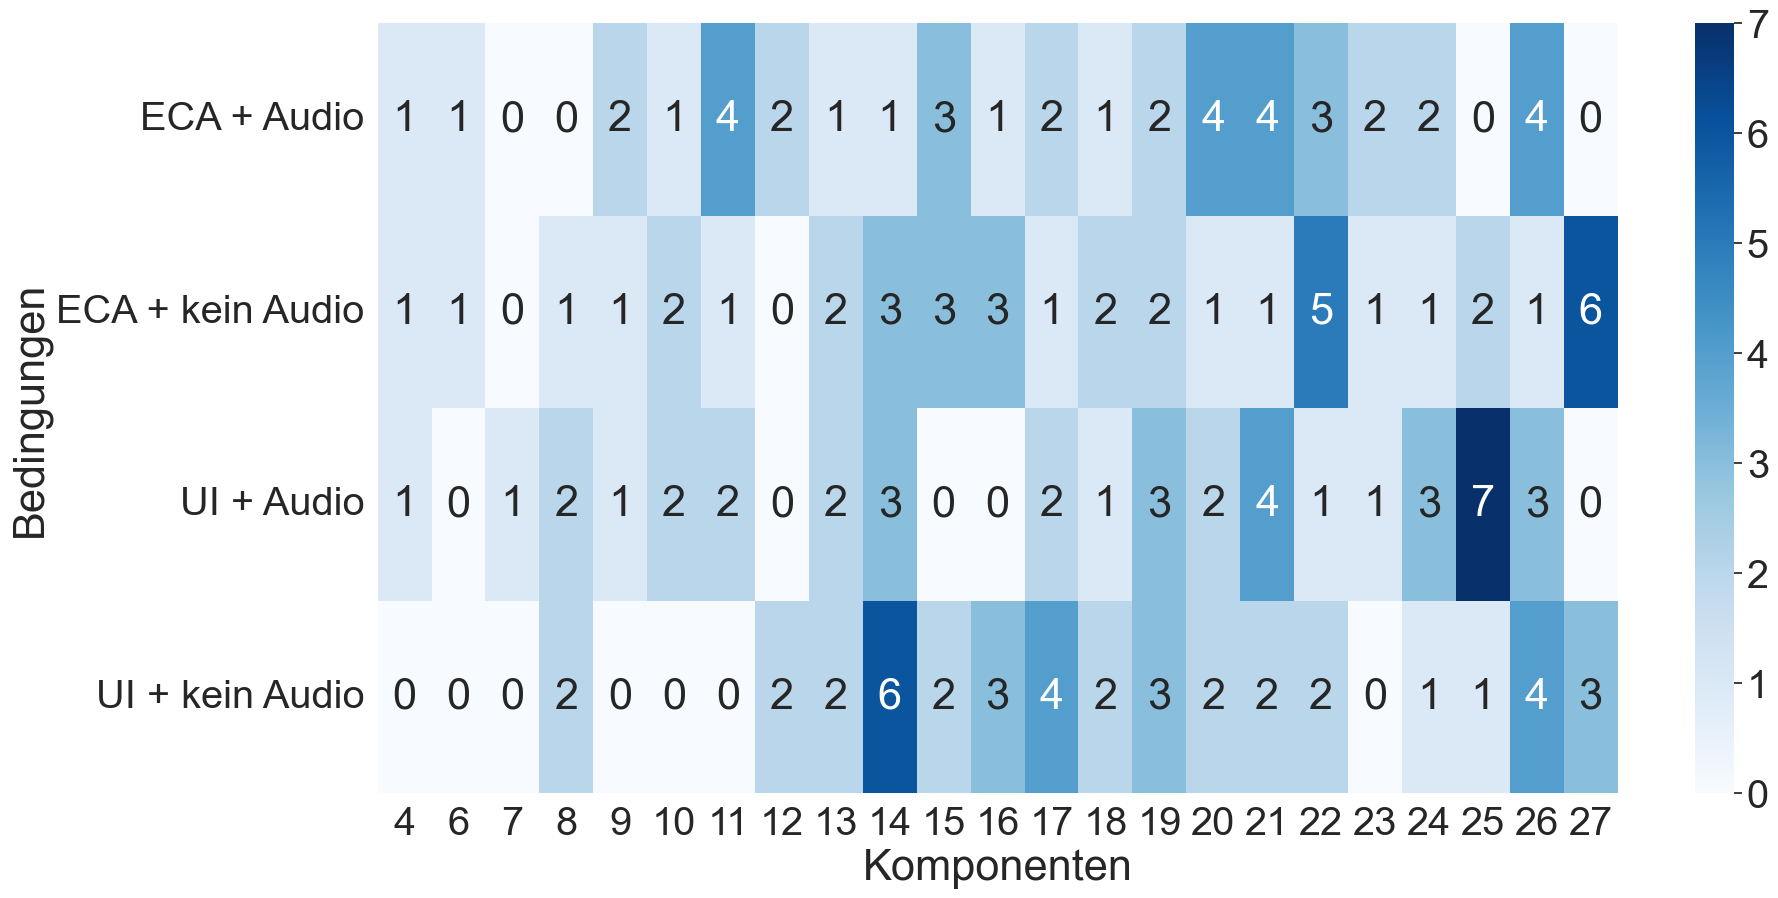

In [41]:
df_pivot = counts_cond.pivot(
    index="Condition",
    columns="Component",
    values="Count"
)

df_pivot = df_pivot.fillna(0)

# plot the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(df_pivot, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Komponenten")
plt.ylabel("Bedingungen")
plt.show()


In [42]:
df_final["WeightedError"] = df_final["Count"] * df_final["Fehlerrate"]

# 2) Gruppierung: sum(WeightedError), sum(Count)
df_weighted = (
    df_final.groupby("Condition", as_index=False)
    .agg({"WeightedError": "sum", "Count": "sum"})
)

# 3) Gewichtete Fehlerrate: Sum(WeightedError) / Sum(Count)
df_weighted["WeightedErrorRate"] = df_weighted["WeightedError"] / df_weighted["Count"]

print(df_weighted)

          Condition  WeightedError  Count  WeightedErrorRate
0       ECA + Audio      18.573285     41           0.453007
1  ECA + kein Audio      15.509898     41           0.378290
2        UI + Audio      17.202647     41           0.419577
3   UI + kein Audio      18.714169     41           0.456443
